In [1]:
# 2 color graph coloring problem circuit
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info.operators import Operator
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram
import networkx as nx

In [2]:
# This function is responsible for looking through the
# edges in the graph and determining the implicit
# constraints between them.
def getImplicitConstraints(graph):
    g = []
    for (u,v) in graph:
        g.append((u,v))
        if (v,u) not in g:
            g.append((v,u))
            
    cmap = dict()
    for (a,b) in g:
        for (c,d) in g:
            u = a; v = b; x = c; y = d
            if (v == x) and (u != y):
                if y <= u:
                    u, y = y, u
                if (u,y) not in g:
                    cmap[(u,y)] = (u,y)
    return list(cmap)

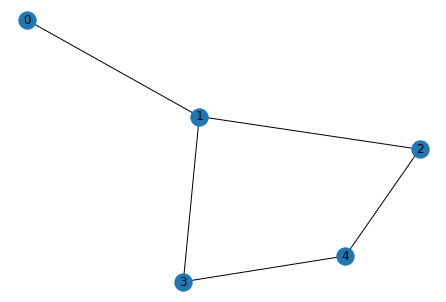

In [3]:
# Define the graph by giving the ends of each edge

g = [(0,1), (1,2), (1,3), (2,4), (3,4)]
# g = [(0,1), (1,2), (2,3)]

# get the implict constraints between vertices which
# have a common neighbour
cons = getImplicitConstraints(g)

nVert = max(max(g))+1
nodes = list(range(nVert))
nEdges = len(g)
nCons = len(cons)

# list of all constraints to apply to graph
cg = []
cg.extend(cons)
cg.extend(g)

# Sort the constraints to ensure the implicit constraints
#   are after the corresponding explicit contraints
# The edges are the explicit constraints and the pair of vertices
#   which have a common neighbour are the implicit constraints.
# Sorting the constraints is import because this will affect the order
#   in which the circuit circuit is constructed.
# Example:
#           g = [(0,1), (1,2)]
# (0,2) is an implicit constraint because we want to maximize the
#   number of colors used so ideally vertices 0 and 2 must have
#   different coloring
# So the constraint graph should be in the orders: cg = [(0,1), (0,2), (1,2)]

cg.sort()

# view the graph
ngx = nx.Graph()
for i in g:
    ngx.add_edge(i[0], i[1])
nx.draw(ngx, with_labels=True)

In [4]:
ce = 2
# Create a Quantum Circuit
qv = QuantumRegister(ce*nVert)
q = QuantumRegister(ce*(nEdges+nCons))
c = ClassicalRegister(ce*nVert)
qc = QuantumCircuit(qv,q,c)


In [5]:
# Add the gates to the circuit for each edge in the graph
for i in range(nVert*ce):
    qc.h(i)

# remove the |11> state because we only require 3 colors
remov_op = Operator([[3, 1, -1, 1], [-1, 3, 1, 1], [1, -1, 3, 1], [-1, -1, -1, 3]]/(2*np.sqrt(3)))

for i in range(0,nVert*2,2):
    qc.unitary(remov_op, [i, i+1], label='remov 11')

# The three transition above create a circular transition when two vertices
#   have the same color/state
# Two |00> vertices cause the second vertex to transition to |01>
#               |00>x|00> ---> |00>x|01>
# Two |01> vertices cause the second vertex to transition to |10>
#               |01>x|01> ---> |01>x|10>
# Two |10> vertices cause the second vertex to transition to |00>
#               |10>x|10> ---> |10>x|00>
# Two |11> vertices doesnt cause any transition

k = nVert*ce
for edge in cg:
    i = edge[0]*ce
    j = edge[1]*ce

    qc.ccx(i,j,k)
    qc.ccx(i+1,j+1,k+1)

    # to transition the |01>x|01> ---> |01>x|10>
    qc.cx(k+1,j)
    qc.cx(k+1,j+1)
    
    # to transition the |10>x|10> ---> |10>x|00>
    qc.cx(k,k+1)
    qc.cx(k,j)
    qc.cx(k,j+1)

    qc.x(i)
    qc.x(i+1)
    qc.x(j)
    qc.x(j+1)
    qc.ccx(i,j,k)
    qc.ccx(i+1,j+1,k+1)
    qc.x(i)
    qc.x(i+1)
    qc.x(j)
    qc.x(j+1)

    # to transition the |00>x|00> ---> |00>x|01>
    qc.ccx(k+1,k,j+1)

    qc.barrier()

    k += 2

# measure all the input qubits
qc.measure(qv,c)

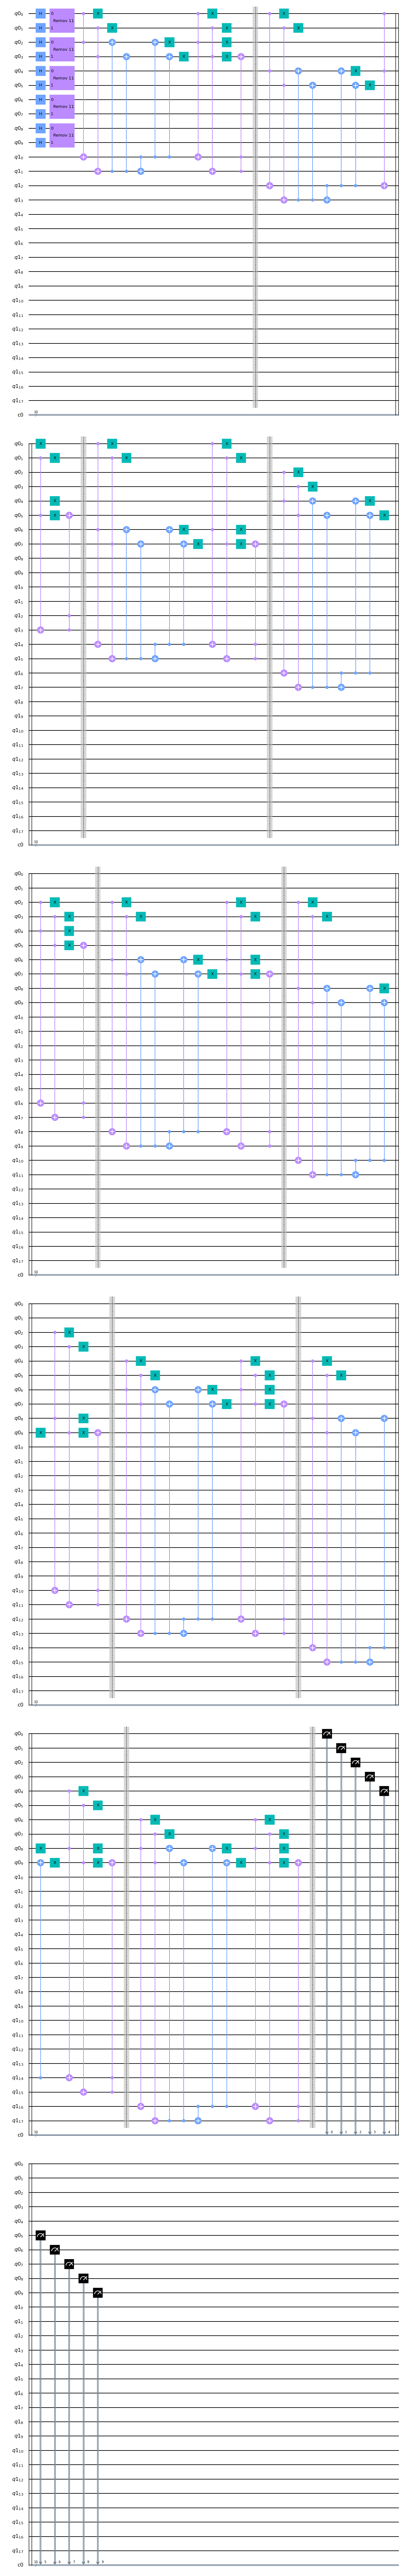

In [6]:
#--------------- Drawing
qc.draw(output='mpl')

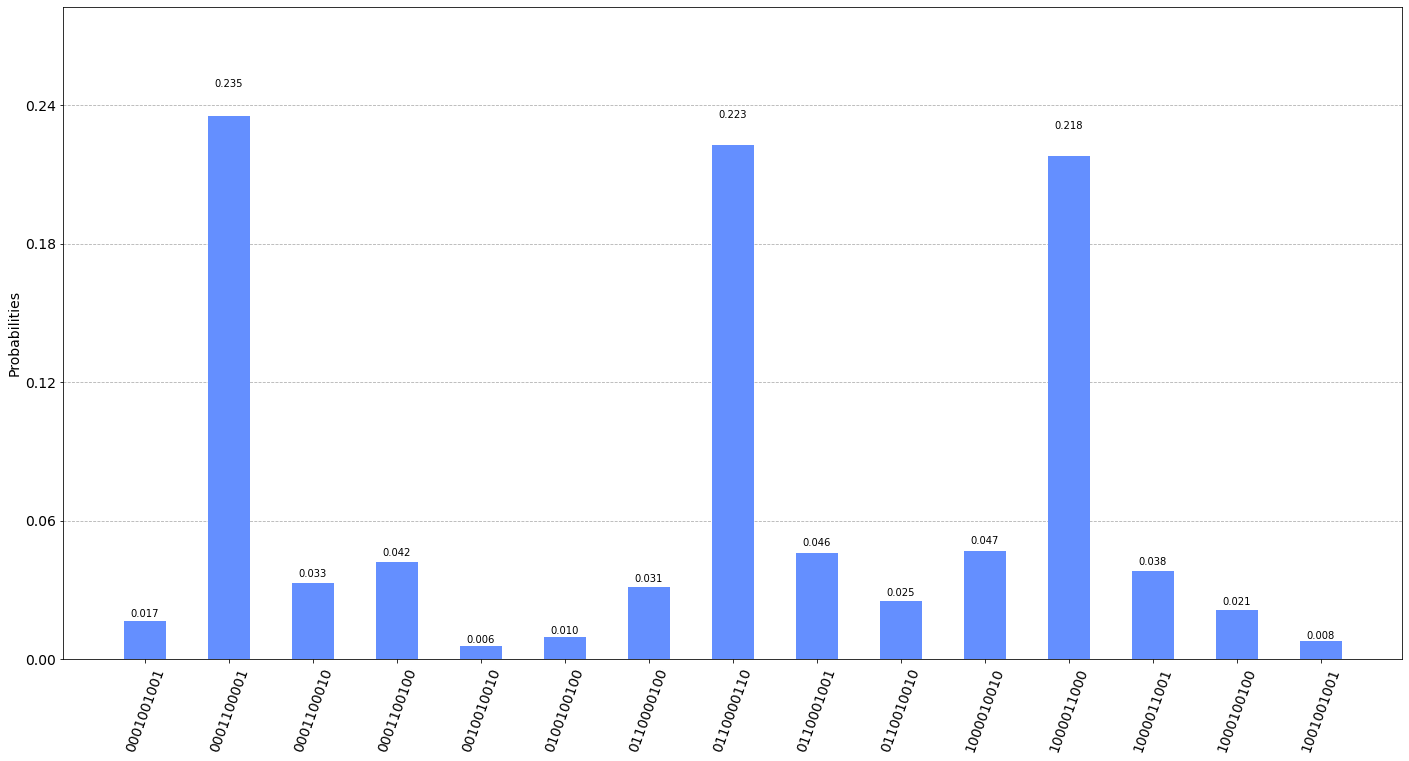

In [7]:
# Use Aer's qasm_simulator
backend_qasm_sim = Aer.get_backend('qasm_simulator')
job_sim = execute(qc, backend_qasm_sim, shots=1024)

# display the results
result_qasm_sim = job_sim.result()
counts = result_qasm_sim.get_counts()
# print(counts)

plot_histogram(counts, figsize=(24,12))

In [8]:
# used check the results and to see if any of the
# outputs contain any pairs of vertices which have
# the same coloring assigned. If so then this function
# return false.
def uniqueCharacters(st):
    # Using sorting
    # sorted(st)
    for i in range(len(st)-2):
        # if at any time, 2 adjacent
        # elements become equal,
        # return false
        if (st[i] == st[i + 1]):
            return False
        if (i < (len(st)-2)) and (st[i] == st[i + 2]):
            return False
    return True

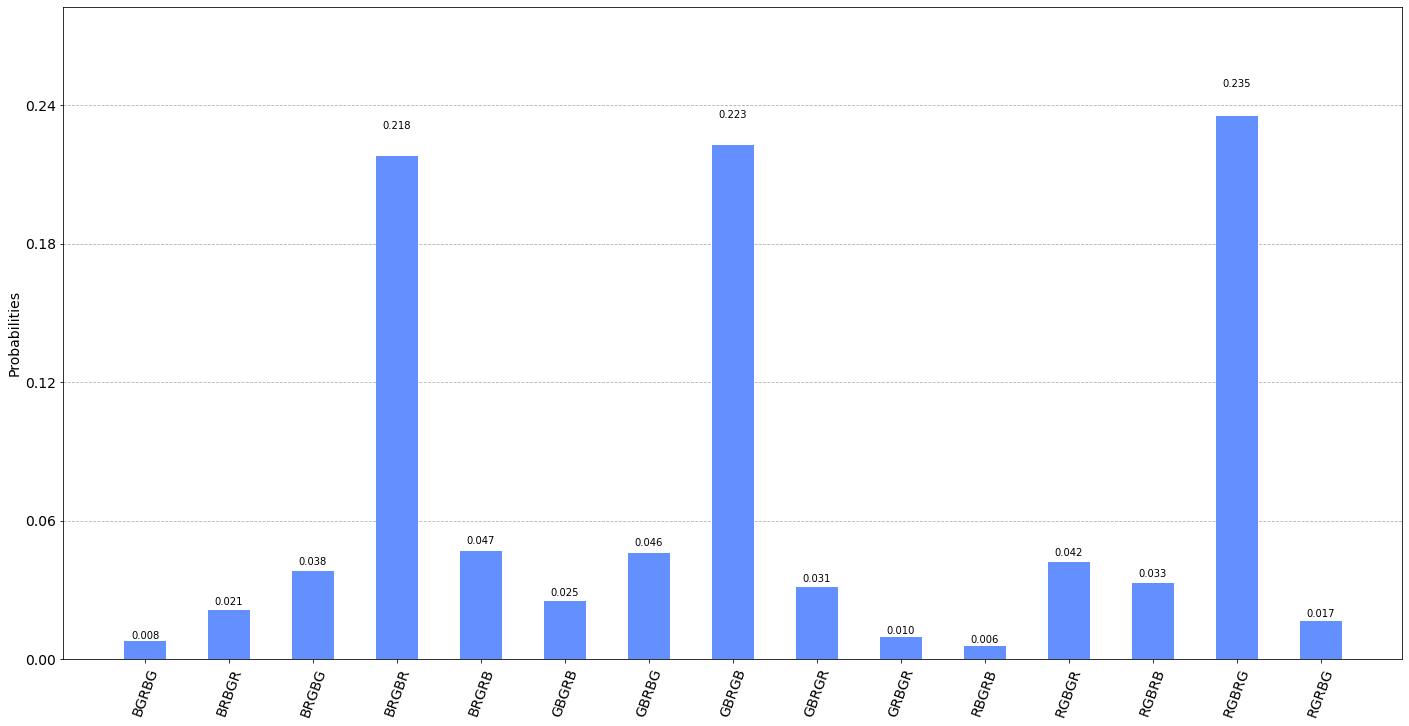

In [9]:
cMap = {'00':'R', '01':'G', '10':'B', '11':'X'}
colorCoded = dict()
colorCoded3 = dict()
for k in counts:
    s = ""
    i = 0
    while i < len(k):
        s += cMap[k[i:i+2]]
        i += 2
    colorCoded[s] = counts[k]
    if uniqueCharacters(s):
        colorCoded3[s] = counts[k]

# sort the results to better visualize
colorCoded = {k: v for k, v in sorted(colorCoded.items(), key=lambda item: item[1], reverse=True)}
plot_histogram(colorCoded, figsize=(24,12))

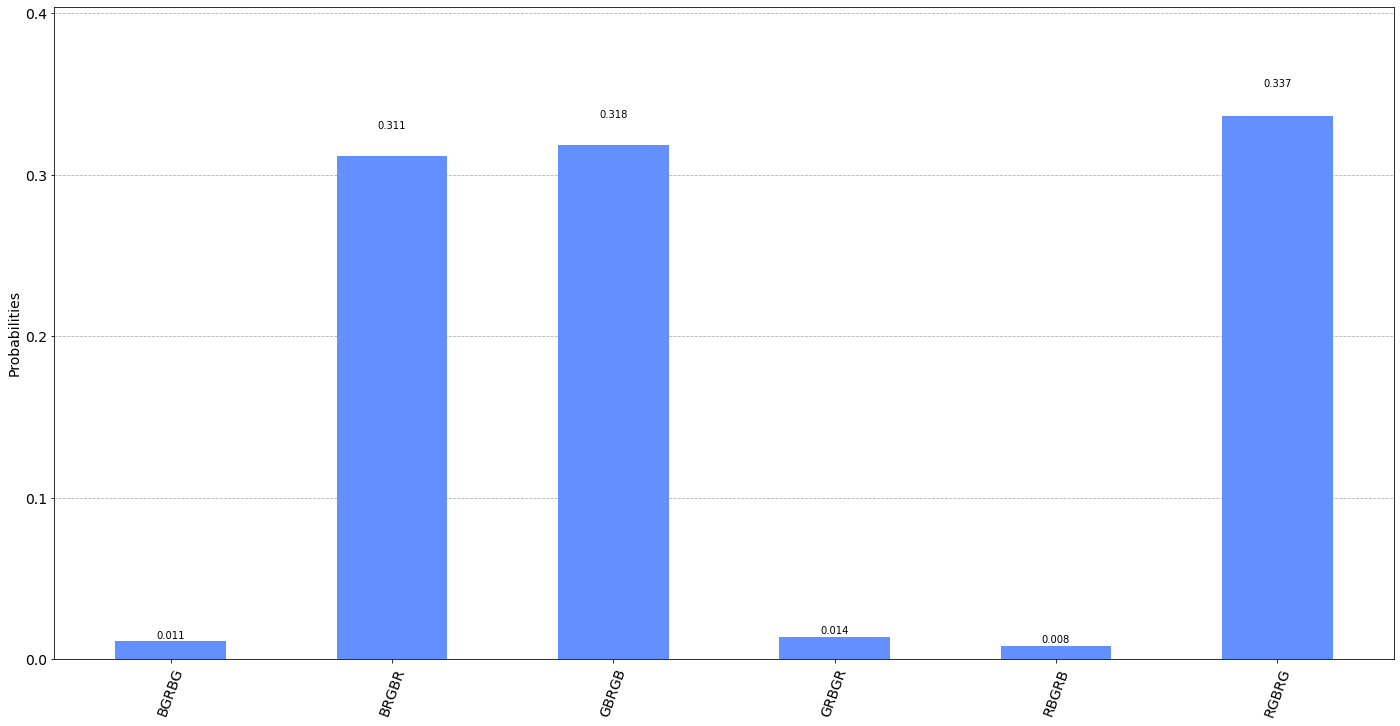

In [10]:
colorCoded3 = {k: v for k, v in sorted(colorCoded3.items(), key=lambda item: item[1], reverse=True)}
plot_histogram(colorCoded3, figsize=(24,12))

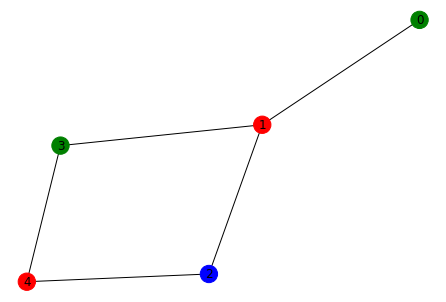

In [11]:
bestColoring = next(iter(colorCoded3))
colorMap = []
for c in reversed(bestColoring):
    if c == 'R':
        colorMap.append('red')
    elif c == 'G':
        colorMap.append('Green')
    elif c == 'B':
        colorMap.append('Blue')
    else:
        colorMap.append('Black')

nx.draw(ngx, node_color=colorMap, with_labels=True)